Training …
baseline accuracy: 100.000%
catastrophic samples: 35 / 450
Fine‑tuning on catastrophic subset …
plugged accuracy : 100.000%


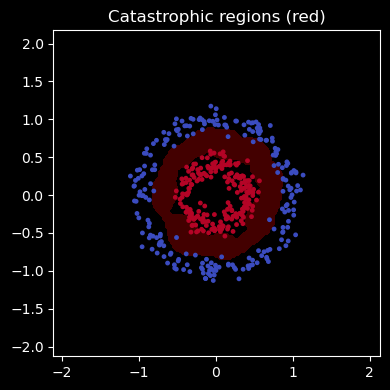

In [1]:
# ------------------------------------------------------------
# Catastrophe Plug‑and‑Evaluate • End‑to‑End Demo  (stable & minimal)
# ------------------------------------------------------------
"""
A stripped‑down, no‑surprises version that runs on CPU **or** CUDA without
any DataLoader generator or pin‑memory pitfalls.

Changes vs. previous draft
–––––––––––––––––––––––––––
1. **Removed the duplicate / malformed `test_loader` line** that was
   causing a stray function call.
2. **No `generator=` argument** → PyTorch picks a matching one internally.
3. Dataset tensors remain on **CPU**, and `pin_memory=False` for safety.

If you still manage to hit a generator device mismatch after this, the
problem is outside this script (eg. global default tensor type changed
elsewhere in your session).
"""

from __future__ import annotations
import numpy as np
import torch
import torch.nn as nn
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt

# ------------------------------
# 1.  Dataset  (CPU tensors)
# ------------------------------
X_np, y_np = make_circles(n_samples=1500, noise=0.08, factor=0.4, random_state=0)
X_tr_np, X_te_np, y_tr_np, y_te_np = train_test_split(
    X_np, y_np, test_size=0.3, stratify=y_np, random_state=0
)
X_tr = torch.tensor(X_tr_np, dtype=torch.float32)
X_te = torch.tensor(X_te_np, dtype=torch.float32)
y_tr = torch.tensor(y_tr_np, dtype=torch.long)
y_te = torch.tensor(y_te_np, dtype=torch.long)

DEVICE = "cpu"
# torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------
# 2.  DataLoaders  (no pin, no custom generator)
# ------------------------------

def make_loader(X: torch.Tensor, y: torch.Tensor, bs: int, shuffle: bool):
    return torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X, y),
        batch_size=bs,
        shuffle=shuffle,
        num_workers=0,
        pin_memory=False,  # dataset is CPU – keep it simple
    )

train_loader = make_loader(X_tr, y_tr, 64,  True)
test_loader = make_loader(X_te, y_te, 256, False)

# ------------------------------
# 3.  Model & helpers
# ------------------------------
model = nn.Sequential(
    nn.Linear(2, 64), nn.ReLU(),
    nn.Linear(64, 32), nn.ReLU(),
    nn.Linear(32, 2),
).to(DEVICE)


def train(model: nn.Module, loader, epochs: int = 50, lr: float = 3e-3):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    ce  = nn.CrossEntropyLoss()
    model.train()
    for _ in range(epochs):
        for X, y in loader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            opt.zero_grad(); ce(model(X), y).backward(); opt.step()


def accuracy(model: nn.Module, loader) -> float:
    model.eval(); correct = total = 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            correct += (model(X).argmax(1) == y).sum().item()
            total   += y.numel()
    return correct / total

print("Training …")
train(model, train_loader)
base_acc = accuracy(model, test_loader)
print(f"baseline accuracy: {base_acc:.3%}")

# ------------------------------
# 4.  Catastrophe mapper (compact)
# ------------------------------
class CatastropheRegionMapper:
    def __init__(self, model: nn.Module, act_thresh: float = 0.1):
        self.m, self.th = model, act_thresh
        self.dev = next(model.parameters()).device
        self.buffer: dict[str, torch.Tensor] = {}

    def _hook(self, _, __, out):
        self.buffer["a"] = out.detach()

    def _run(self, X):
        h = self.m[0].register_forward_hook(self._hook)
        _ = self.m(X); h.remove()

    def fields(self, loader, n_cls):
        self.m.eval(); self.buffer.clear()
        with torch.no_grad():
            # discover width
            X, _ = next(iter(loader))
            self._run(X.to(self.dev))
            width = self.buffer["a"].shape[1]
            nfield = {i: {c: [] for c in range(n_cls)} for i in range(width)}
            self.buffer.clear()
            # fill
            for X, y in loader:
                self._run(X.to(self.dev)); a = self.buffer["a"]
                for i in range(X.size(0)):
                    hot = torch.where(a[i] > self.th)[0].cpu()
                    for n in hot:
                        nfield[n.item()][y[i].item()].append(X[i].numpy())
                self.buffer.clear()
        return nfield

    def catastrophe_map(self, nfield, res=200):
        from sklearn.decomposition import PCA
        pts = [p for d in nfield.values() for v in d.values() for p in v]
        if not pts:
            return None, None, None, None
        pts = np.asarray(pts)
        pca = PCA(2).fit(pts) if pts.shape[1] > 2 else None
        proj = pca.transform if pca else (lambda z: z)
        pts2 = proj(pts)
        (xmin, ymin), (xmax, ymax) = pts2.min(0) - 1, pts2.max(0) + 1
        xs, ys = np.linspace(xmin, xmax, res), np.linspace(ymin, ymax, res)
        cat = np.zeros((res, res))
        for ix, xx in enumerate(xs):
            for iy, yy in enumerate(ys):
                p = np.array([xx, yy]); cls = set()
                for d in nfield.values():
                    for c, arr in d.items():
                        if arr and np.min(np.linalg.norm(proj(np.array(arr)) - p, axis=1)) < 0.3:
                            cls.add(c)
                cat[iy, ix] = len(cls) if len(cls) > 1 else 0
        return cat, xs, ys, pca

mapper = CatastropheRegionMapper(model)
fields = mapper.fields(test_loader, n_cls=2)
cat, xs, ys, pca = mapper.catastrophe_map(fields)

# ------------------------------
# 5.  Identify & plug failures
# ------------------------------
interp = RegularGridInterpolator((ys, xs), cat > 0, bounds_error=False, fill_value=False)
coords = pca.transform(X_te) if pca else X_te.numpy()
mask = interp(coords).astype(bool)
print(f"catastrophic samples: {mask.sum()} / {len(mask)}")

if mask.any():
    plug_loader = make_loader(X_te[mask], y_te[mask], 128, True)
    print("Fine‑tuning on catastrophic subset …")
    train(model, plug_loader, epochs=10, lr=1e-3)

plugged_acc = accuracy(model, test_loader)
print(f"plugged accuracy : {plugged_acc:.3%}")

# ------------------------------
# 6.  Visualisation
# ------------------------------
plt.figure(figsize=(4, 4))
plt.contourf(xs, ys, cat, levels=[0, 0.5, 2], colors=["#ffffff00", "#ff000044"])
plt.scatter(coords[:, 0], coords[:, 1], c=y_te, cmap="coolwarm", s=6)
plt.title("Catastrophic regions (red)")
plt.tight_layout()
plt.show()
